In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from se3_cnn import basis_kernels
from se3_cnn import SO3

In [3]:
size = 7
n_radial = size//2+1 # hard coded
upsampling = 1 # hard coded

reps = [SO3.repr1, SO3.repr3, SO3.repr5, SO3.repr7, SO3.repr9, SO3.repr11]
order_in = 2
order_out = 1
R_in = reps[order_in]
R_out = reps[order_out]

basis = basis_kernels.cube_basis_kernels_analytical(size, n_radial, upsampling, R_out, R_in)

print('basis of shape', basis.shape)

compute kernels_cache_analytical/0.pkl.gz... irreps multiplett orders:  [1 2 3]  dimensionalities:  [3 5 7]
rank of 1-th subspace solution for Q = 3
rank of 2-th subspace solution for Q = 7
rank of 3-th subspace solution for Q = 5
rank of summed basis solutions for Q =  15

kernel size: 7
shell radii: [0 1 2 3]
shell bandlimit: [0 4 6 8]

check_basis_equivariance for R_in=repr5 -> R_out=repr3:
[ 0.36825005  0.27076267  0.19937395  0.36562337  0.23616401  0.18766486
  0.28043957  0.1689284   0.13979195]
save kernels_cache_analytical/0.pkl.gz... done
basis of shape (9, 3, 5, 7, 7, 7)


In [5]:
avg_equiv = np.zeros(len(basis))
N_samples = 100
for a,b,c in 2*np.pi*np.random.rand(N_samples,3):
    avg_equiv += basis_kernels.check_basis_equivariance(basis, R_out, R_in, a,b,c)
avg_equiv /= N_samples
print(avg_equiv)

[ 0.30424631  0.220545    0.15537164  0.30223807  0.18528238  0.1304992
  0.23114305  0.1320318   0.09680146]


#################################################################
Basis element 0
#################################################################

out channel m = -1
in channel n = -2


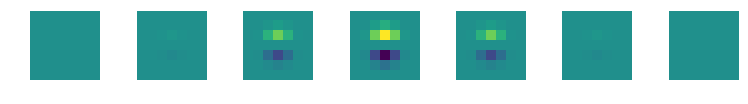

in channel n = -1


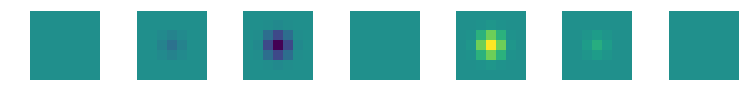

in channel n = 0


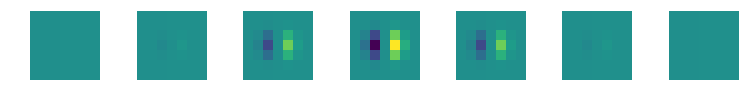

in channel n = 1


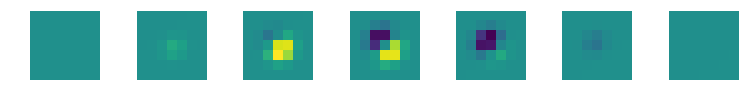

in channel n = 2


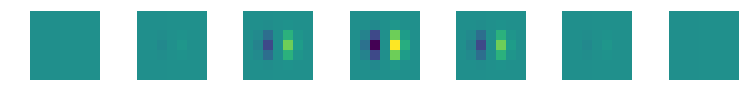


out channel m = 0
in channel n = -2


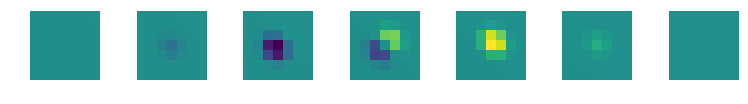

in channel n = -1


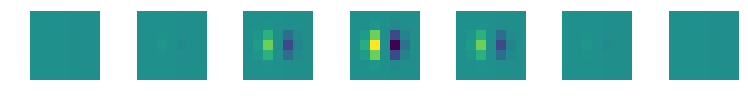

in channel n = 0


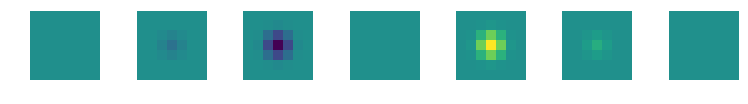

in channel n = 1


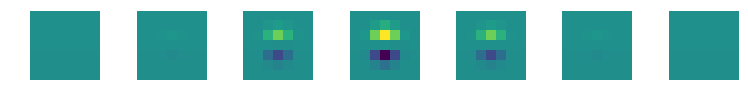

in channel n = 2


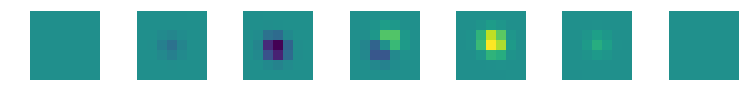


out channel m = 1
in channel n = -2


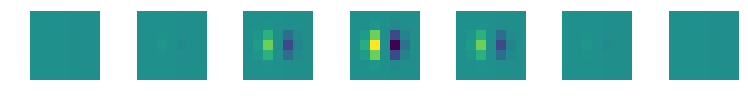

in channel n = -1


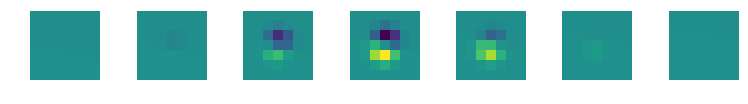

in channel n = 0


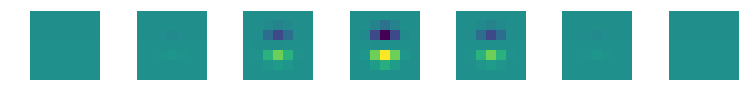

in channel n = 1


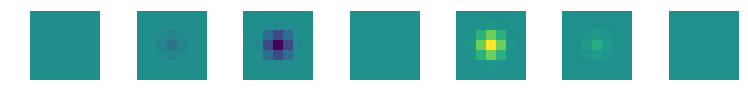

in channel n = 2


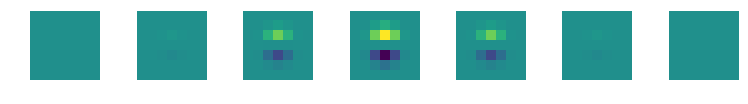

#################################################################
Basis element 1
#################################################################

out channel m = -1
in channel n = -2


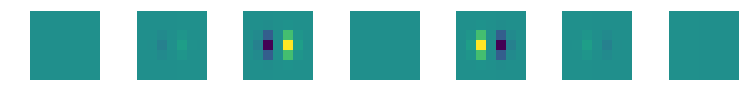

in channel n = -1


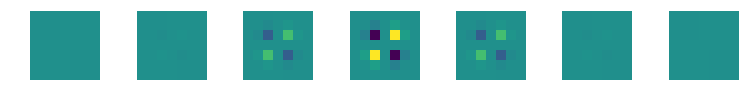

in channel n = 0


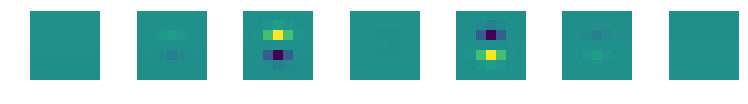

in channel n = 1


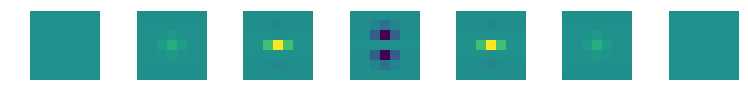

in channel n = 2


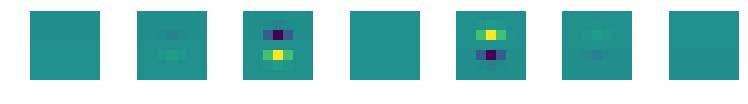


out channel m = 0
in channel n = -2


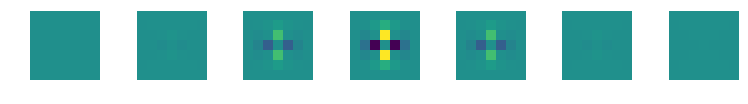

in channel n = -1


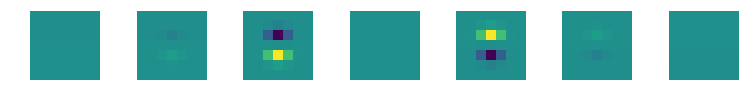

in channel n = 0


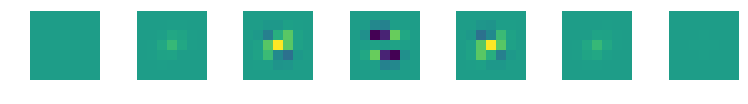

in channel n = 1


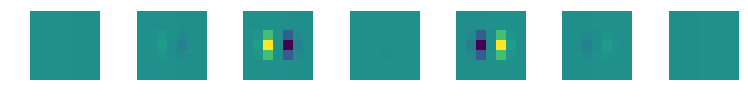

in channel n = 2


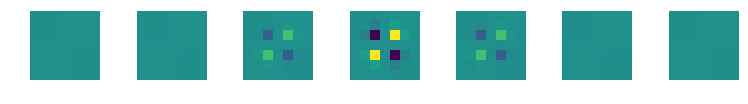


out channel m = 1
in channel n = -2


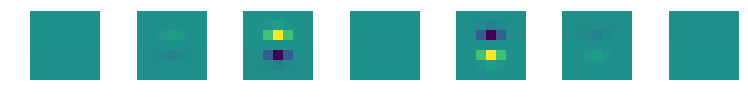

in channel n = -1


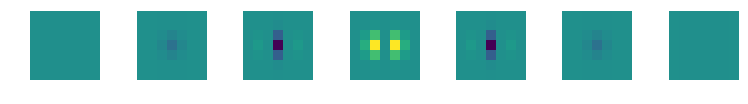

in channel n = 0


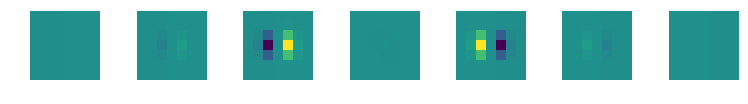

in channel n = 1


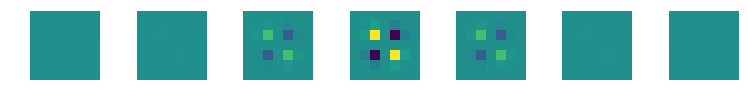

in channel n = 2


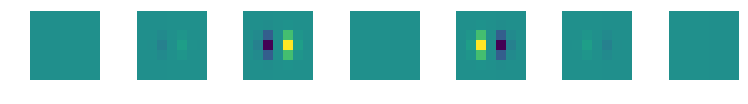

#################################################################
Basis element 2
#################################################################

out channel m = -1
in channel n = -2


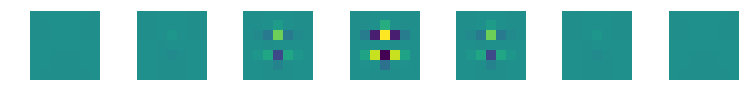

in channel n = -1


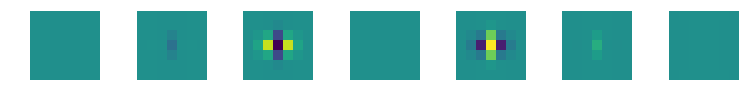

in channel n = 0


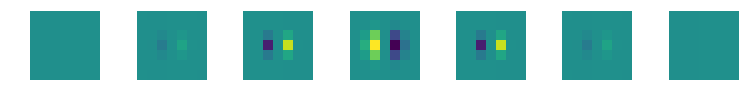

in channel n = 1


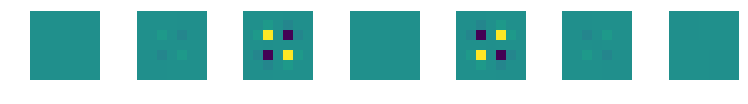

in channel n = 2


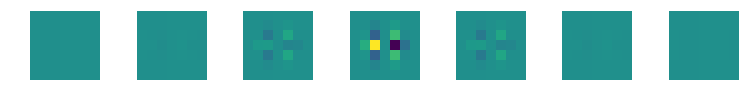


out channel m = 0
in channel n = -2


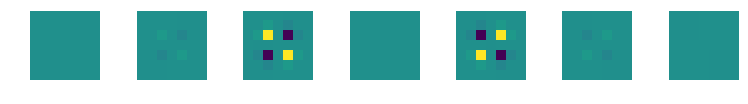

in channel n = -1


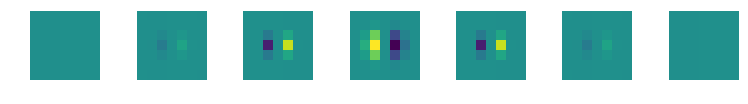

in channel n = 0


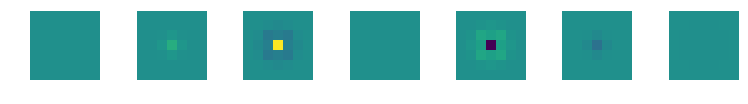

in channel n = 1


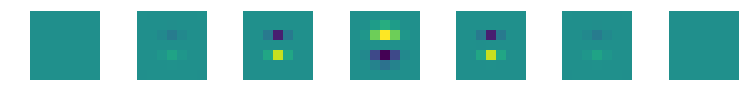

in channel n = 2


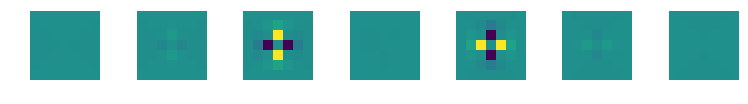


out channel m = 1
in channel n = -2


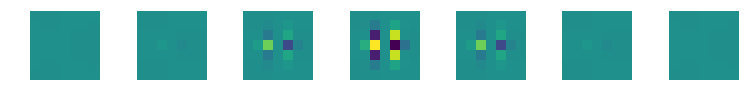

in channel n = -1


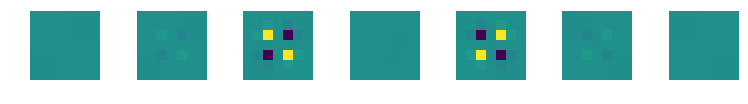

in channel n = 0


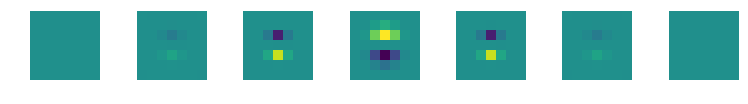

in channel n = 1


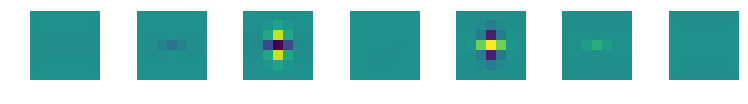

in channel n = 2


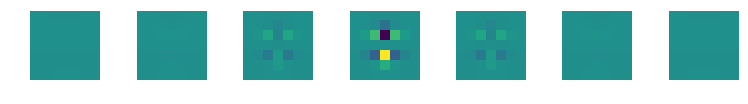

#################################################################
Basis element 3
#################################################################

out channel m = -1
in channel n = -2


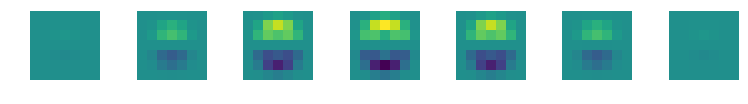

in channel n = -1


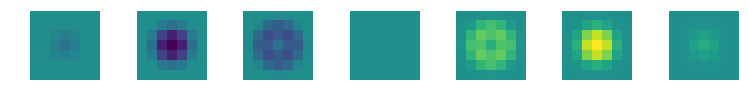

in channel n = 0


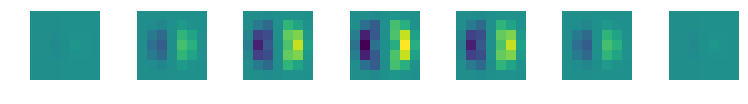

in channel n = 1


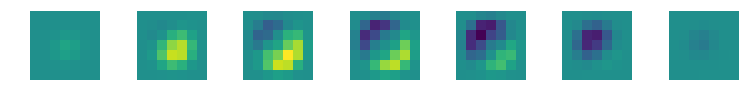

in channel n = 2


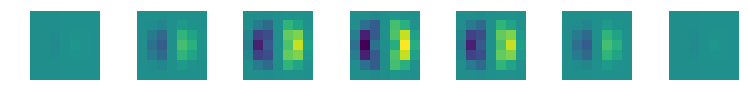


out channel m = 0
in channel n = -2


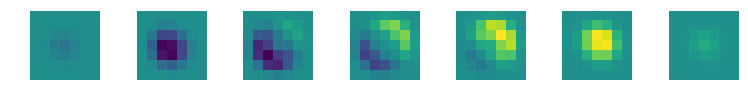

in channel n = -1


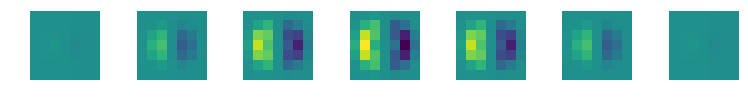

in channel n = 0


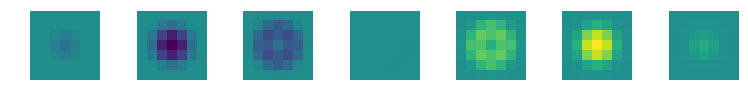

in channel n = 1


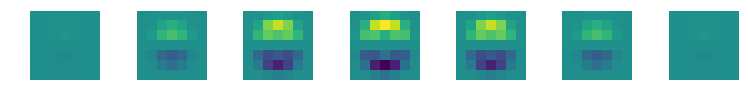

in channel n = 2


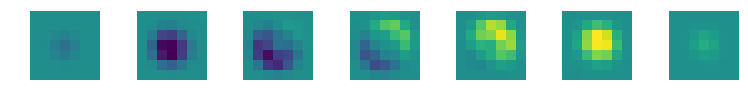


out channel m = 1
in channel n = -2


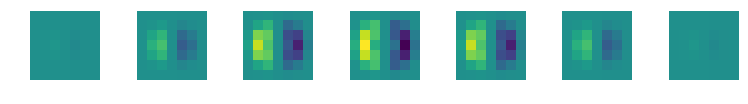

in channel n = -1


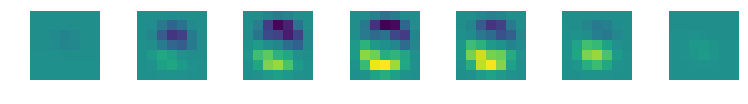

in channel n = 0


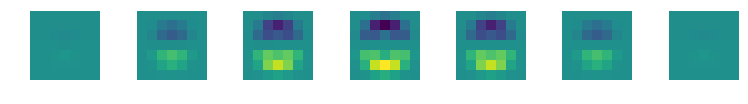

in channel n = 1


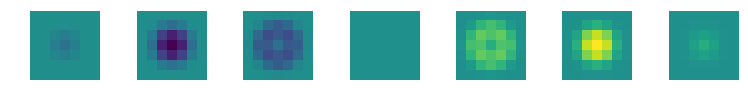

in channel n = 2


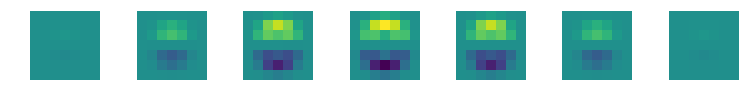

#################################################################
Basis element 4
#################################################################

out channel m = -1
in channel n = -2


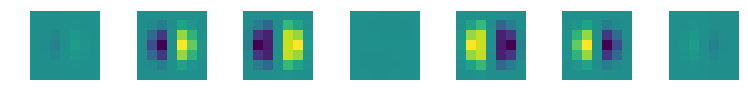

in channel n = -1


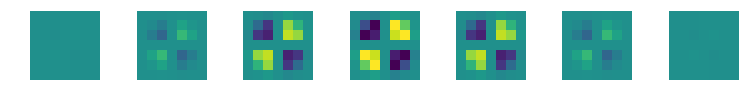

in channel n = 0


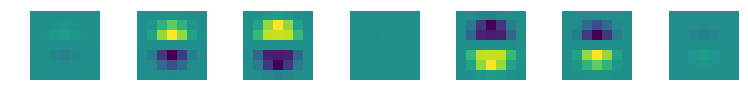

in channel n = 1


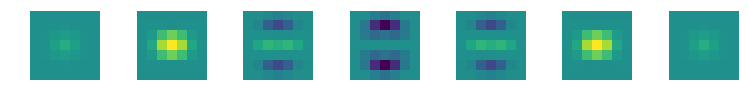

in channel n = 2


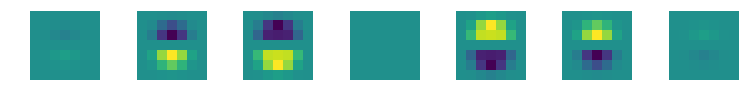


out channel m = 0
in channel n = -2


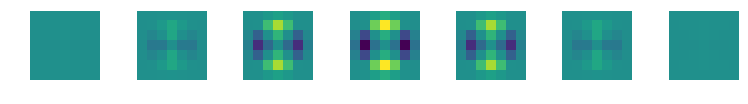

in channel n = -1


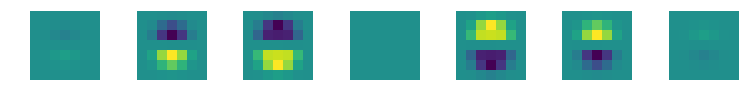

in channel n = 0


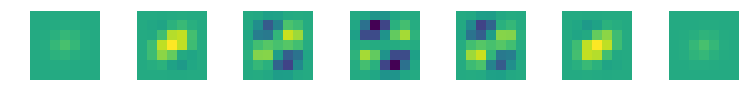

in channel n = 1


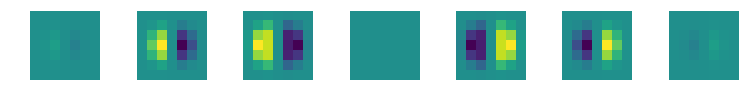

in channel n = 2


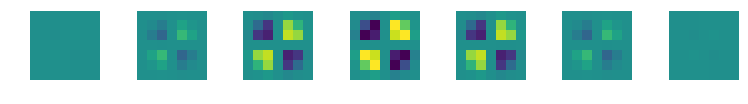


out channel m = 1
in channel n = -2


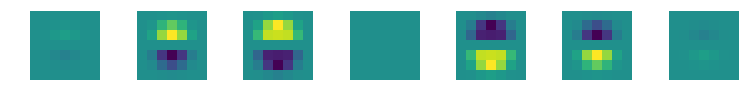

in channel n = -1


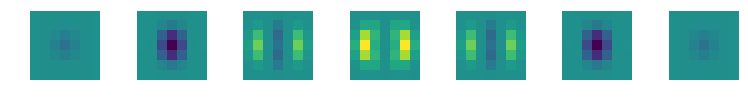

in channel n = 0


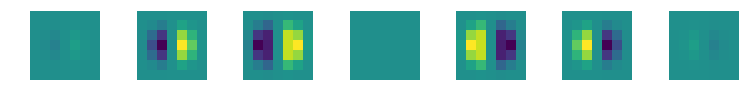

in channel n = 1


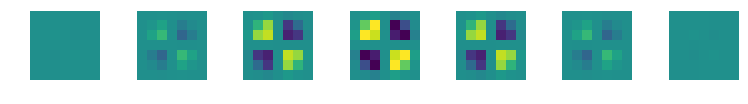

in channel n = 2


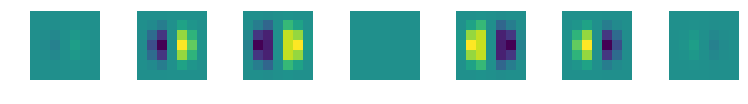

#################################################################
Basis element 5
#################################################################

out channel m = -1
in channel n = -2


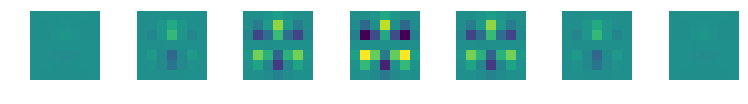

in channel n = -1


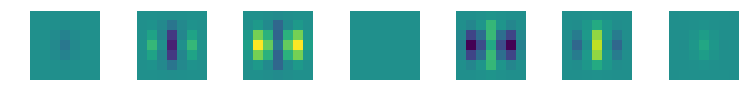

in channel n = 0


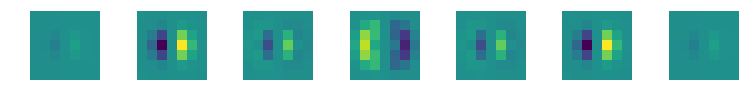

in channel n = 1


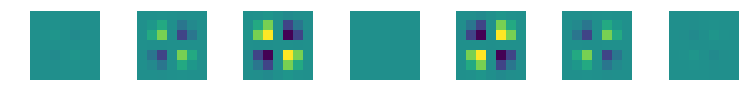

in channel n = 2


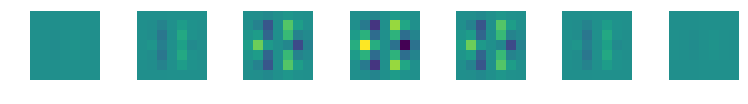


out channel m = 0
in channel n = -2


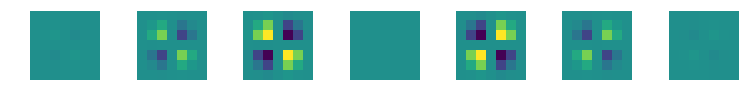

in channel n = -1


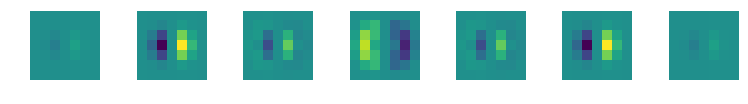

in channel n = 0


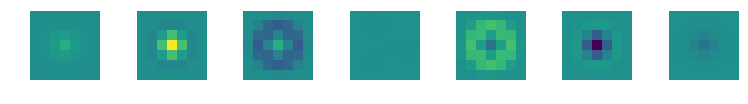

in channel n = 1


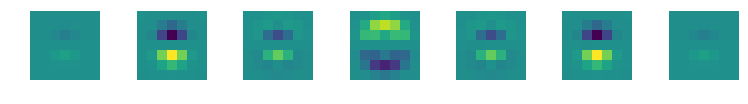

in channel n = 2


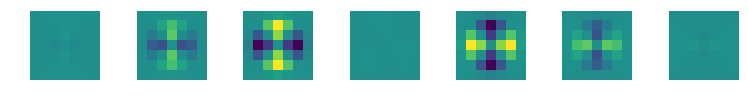


out channel m = 1
in channel n = -2


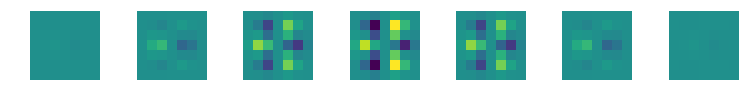

in channel n = -1


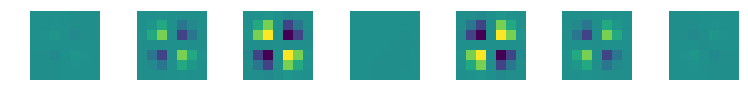

in channel n = 0


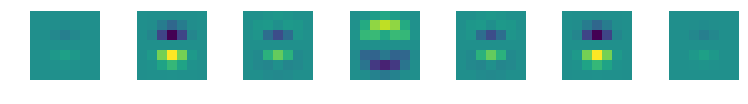

in channel n = 1


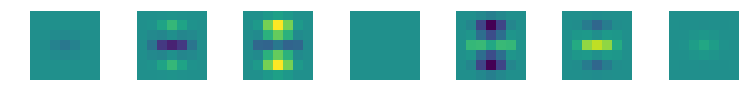

in channel n = 2


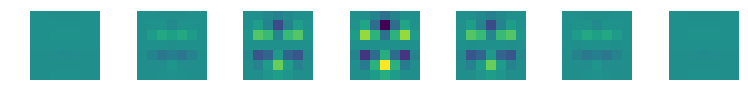

#################################################################
Basis element 6
#################################################################

out channel m = -1
in channel n = -2


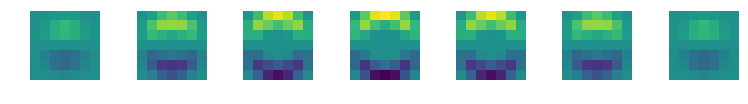

in channel n = -1


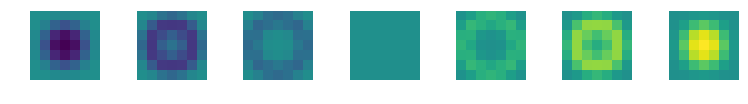

in channel n = 0


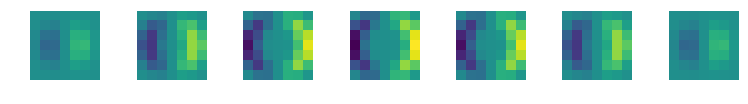

in channel n = 1


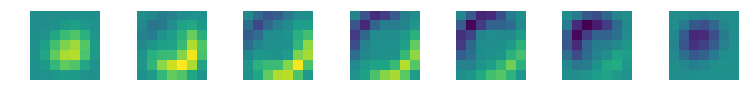

in channel n = 2


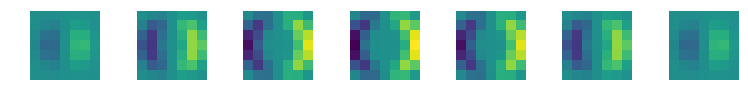


out channel m = 0
in channel n = -2


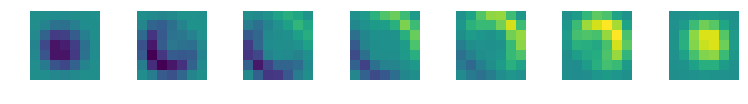

in channel n = -1


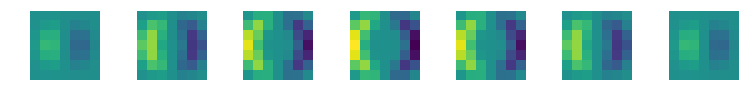

in channel n = 0


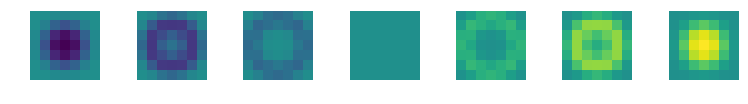

in channel n = 1


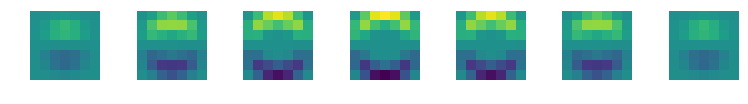

in channel n = 2


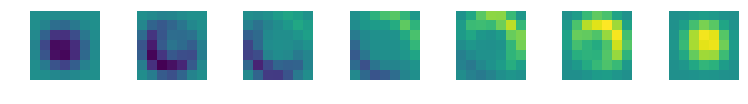


out channel m = 1
in channel n = -2


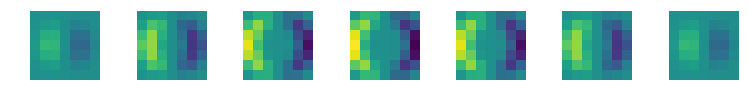

in channel n = -1


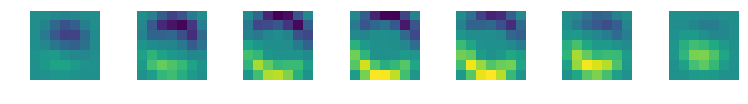

in channel n = 0


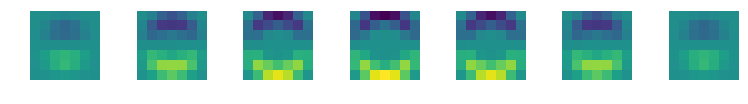

in channel n = 1


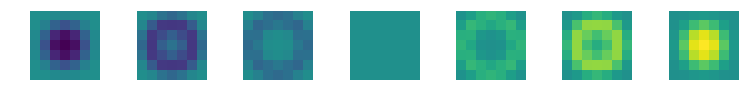

in channel n = 2


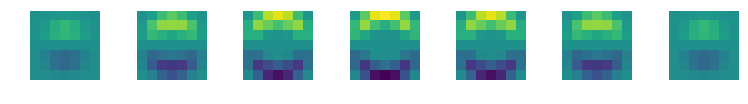

#################################################################
Basis element 7
#################################################################

out channel m = -1
in channel n = -2


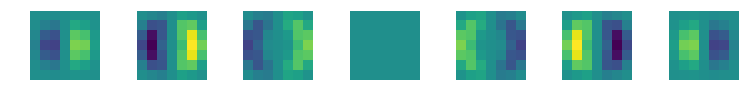

in channel n = -1


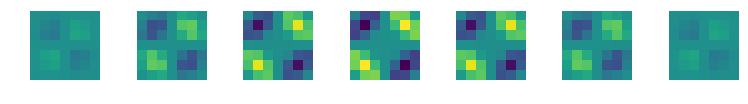

in channel n = 0


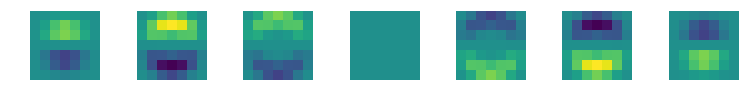

in channel n = 1


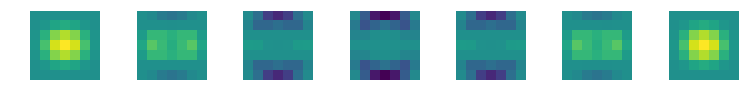

in channel n = 2


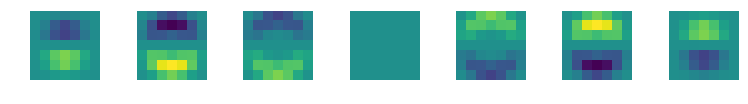


out channel m = 0
in channel n = -2


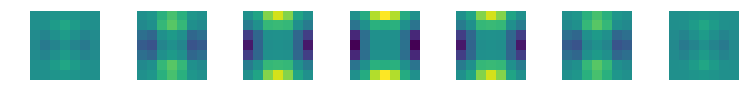

in channel n = -1


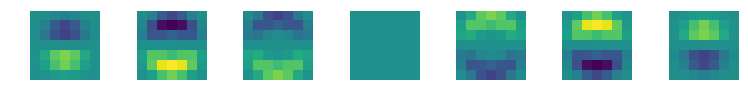

in channel n = 0


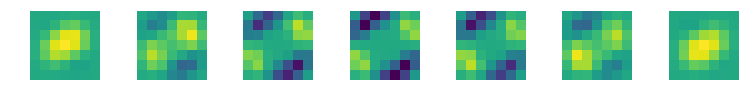

in channel n = 1


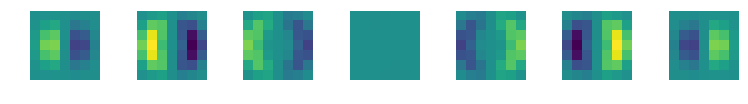

in channel n = 2


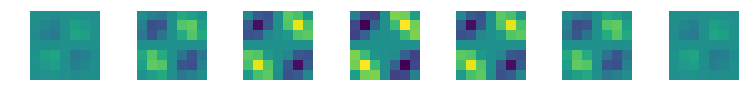


out channel m = 1
in channel n = -2


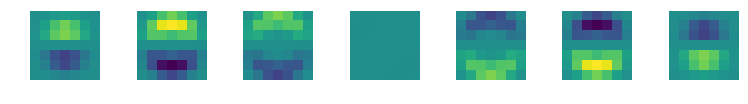

in channel n = -1


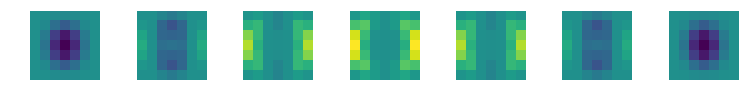

in channel n = 0


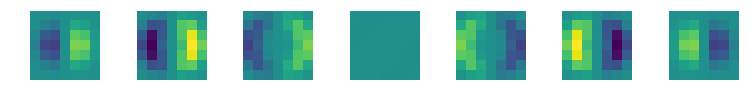

in channel n = 1


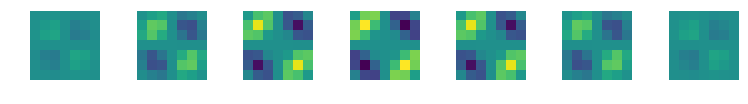

in channel n = 2


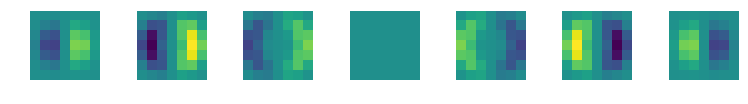

#################################################################
Basis element 8
#################################################################

out channel m = -1
in channel n = -2


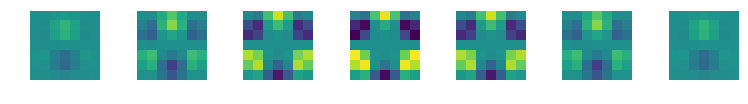

in channel n = -1


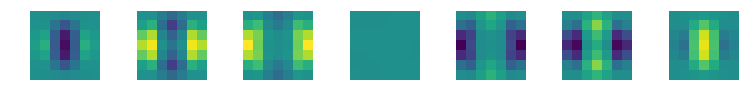

in channel n = 0


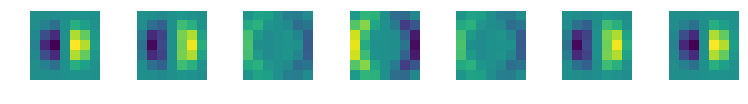

in channel n = 1


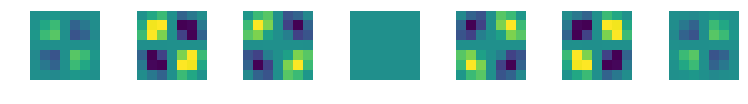

in channel n = 2


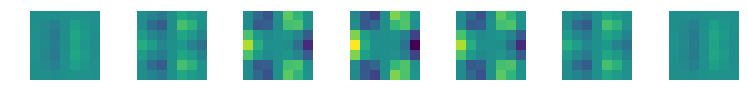


out channel m = 0
in channel n = -2


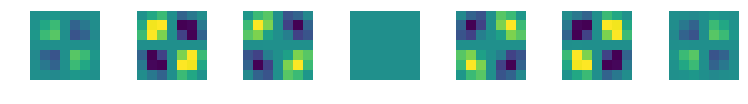

in channel n = -1


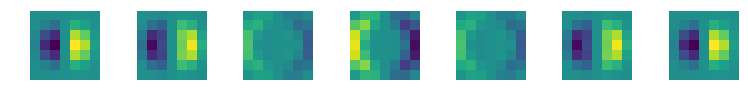

in channel n = 0


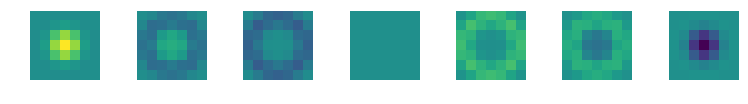

in channel n = 1


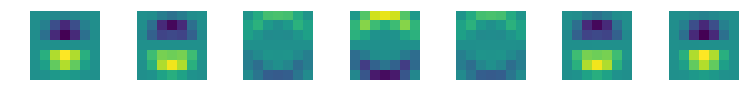

in channel n = 2


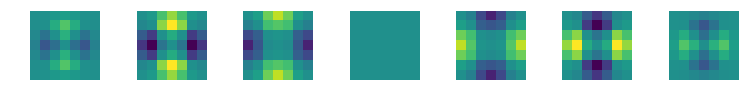


out channel m = 1
in channel n = -2


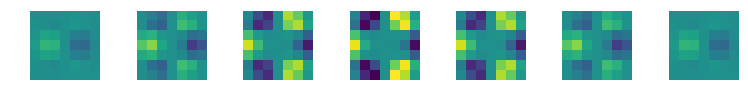

in channel n = -1


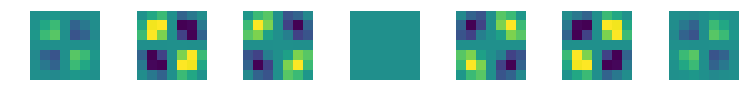

in channel n = 0


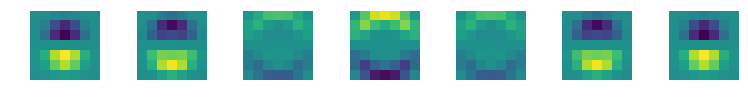

in channel n = 1


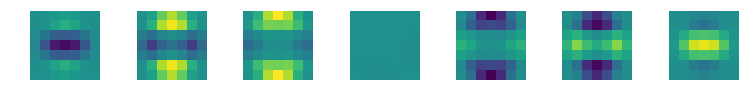

in channel n = 2


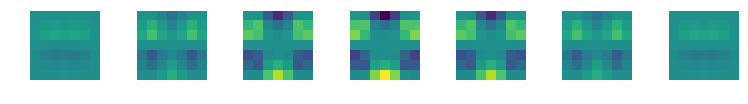

In [6]:
def plot_cube(cube):
    vmin, vmax = cube.min(), cube.max()
    size = cube.shape[-1]
    plt.figure(figsize=(1.5*size, 1.5))
    for idx_z in range(size):
        plt.subplot(1, 7, idx_z+1)
        plt.imshow(cube[:,:,idx_z], vmin=vmin, vmax=vmax)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

for idx_basis,b_elem in enumerate(basis):
    print('#################################################################')
    print('Basis element {}'.format(idx_basis))
    print('#################################################################')
    for m,out_ch in zip(np.arange(-order_out, order_out+1), b_elem):
        print('\nout channel m = {}'.format(m))
        for n,in_ch in zip(np.arange(-order_in, order_in+1), out_ch):
            print('in channel n = {}'.format(n))
            plot_cube(in_ch)